In [170]:
import pandas as pd
import numpy as np
import time
import os.path as path
from ast import literal_eval
from itertools import product
import matplotlib.pyplot as plt

In [2]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

/Users/sijiazong/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Prepare datasets(user_item_ratings, game_metadata, game_id_name_pairs)

- User item ratings

In [3]:
user_item_df = pd.read_csv("user_item_played_pair.csv")
user_item_df

,steam_id,item_id
0,76561197970982479,10
1,76561197970982479,30
2,76561197970982479,300
3,76561197970982479,240
4,76561197970982479,3830
...,...,...
3246347,76561198329548331,304930
3246348,76561198329548331,227940
3246349,76561198329548331,388490
3246350,76561198329548331,521570


In [4]:
user_item_df[user_item_df.steam_id==317160]

,steam_id,item_id


In [5]:
user_item_df[user_item_df.item_id==317160]

,steam_id,item_id


In [6]:
num_users = user_item_df.steam_id.nunique()

In [7]:
num_items = user_item_df.item_id.nunique()

In [8]:
print('There are {} steam users and {} games.'.format(num_users, num_items))

There are 68403 steam users and 10050 games.


- Games Metadata

In [247]:
games = pd.read_csv("games_metadata.csv")

In [248]:
games.price.value_counts()

4.99      4278
9.99      3902
2.99      3429
0.99      2607
1.99      2541
          ... 
109.99       1
10.49        1
771.71       1
179.00       1
41.99        1
Name: price, Length: 145, dtype: int64

In [249]:
# create feature for game price category
bins = [-1, 0, 10, 60, 1000]
labels= ['Free', 'Low', 'Midum', 'High']
games['price_category'] = pd.cut(games['price'], bins=bins, labels=labels)

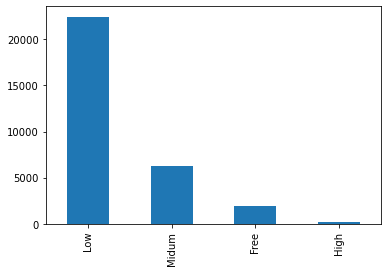

In [250]:
pd.value_counts(games['price_category']).plot(kind="bar")

In [251]:
# create feature for game release year
games['release_year'] = games['release_date'].apply(lambda s: pd.to_datetime(s, errors='coerce').year)

In [252]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32131 entries, 0 to 32130
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   publisher       24071 non-null  object  
 1   genres          28849 non-null  object  
 2   app_name        32131 non-null  object  
 3   title           30083 non-null  object  
 4   url             32131 non-null  object  
 5   release_date    30065 non-null  object  
 6   tags            31969 non-null  object  
 7   discount_price  224 non-null    float64 
 8   reviews_url     32131 non-null  object  
 9   specs           31462 non-null  object  
 10  price           30747 non-null  float64 
 11  early_access    32131 non-null  bool    
 12  id              32131 non-null  float64 
 13  developer       28834 non-null  object  
 14  sentiment       24950 non-null  object  
 15  metascore       2605 non-null   float64 
 16  item_id         2334 non-null   float64 
 17  bundles     

- All game id/name pair in both metadata/useritem pair

In [253]:
all_games = pd.read_csv("all_games_id_name_pair.csv")

In [254]:
games[games.id == 317160]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,item_id,bundles,price_category,release_year


In [255]:
all_games[all_games.item_id == 317160]

,item_id,item_name


## Building functions to generate item features data

In [256]:
games[['publisher', 'developer', 'genres', 'tags', 'specs', 'bundles', 'price', 'release_year']]

,publisher,developer,genres,tags,specs,bundles,price,release_year
0,Kotoshiro,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],NaN,4.99,2018.0
1,"Making Fun, Inc.",Secret Level SRL,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",NaN,0.00,2018.0
2,Poolians.com,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",NaN,0.00,2017.0
3,彼岸领域,彼岸领域,"['Action', 'Adventure', 'Casual']","['Action', 'Adventure', 'Casual']",['Single-player'],NaN,0.99,2017.0
4,NaN,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",NaN,2.99,NaN
...,...,...,...,...,...,...,...,...
32126,Ghost_RUS Games,"Nikita ""Ghost_RUS""","['Casual', 'Indie', 'Simulation', 'Strategy']","['Strategy', 'Indie', 'Casual', 'Simulation']","['Single-player', 'Steam Achievements']",NaN,1.99,2018.0
32127,Sacada,Sacada,"['Casual', 'Indie', 'Strategy']","['Strategy', 'Indie', 'Casual']","['Single-player', 'Steam Achievements', 'Steam...",NaN,4.99,2018.0
32128,Laush Studio,Laush Dmitriy Sergeevich,"['Indie', 'Racing', 'Simulation']","['Indie', 'Simulation', 'Racing']","['Single-player', 'Steam Achievements', 'Steam...",NaN,1.99,2018.0
32129,SIXNAILS,"xropi,stev3ns","['Casual', 'Indie']","['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...","['Single-player', 'Steam Achievements', 'Steam...",NaN,4.99,2017.0


In [19]:
# price_category: 4
# specs: 40
# genres: 22
# tags: 339
# genres + specs: 62(genres and specs are uniquely different)
# genres + tags: 342(a lot of tags are in genres)
# release_year

In [180]:
item_features_cols = ['genres']
# ['publisher', 'genres', 'tags', 'specs', 'price', 'developer', 'release_year']

In [269]:
def build_game_features_list(item_features_cols):
    total_features = set()
    game_features_list = []
    for row in games.itertuples(index=False):
        features = set()
        for col in item_features_cols:
            val = getattr(row, col)
            if pd.isnull(val):
                continue
            if col in {"genres", "tags", "specs", "bundles"}:
                features.update(literal_eval(val))
            else:
                features.add(val)
        game_features_list.append(list(features))
        total_features.update(features)
    return game_features_list, list(total_features)

In [270]:
game_features_list, total_features = build_game_features_list(item_features_cols)

In [272]:
print(len(total_features))

210


In [273]:
def getGameFeaturesData(item_features_cols):
    game_features_list, total_features = build_game_features_list(item_features_cols)
    game_tuple = list(zip(games.id, game_features_list))
    return (total_features, game_tuple)

In [274]:
total_features, game_tuple = getGameFeaturesData(item_features_cols)

In [275]:
print(len(total_features), total_features)

210 [0.0, 0.99, 2.99, 3.99, 4.99, 1.59, 1.99, 6.99, 8.99, 9.99, 10.99, 7.99, 7.49, 12.99, 14.99, 15.99, 13.99, 17.99, 18.99, 19.99, 14.95, 'Software Training', 16.99, 21.99, 24.99, 23.99, 5.0, 20.99, 4.0, 29.99, 29.96, 1.25, 32.99, 0.5, 34.99, 1.5, 36.99, 31.99, 38.85, 39.99, 40.0, 7.0, 'Accounting', 42.99, 'Indie', 44.99, 9.0, 44.98, 41.99, 49.99, 49.0, 'Early Access', 10.93, 10.96, 54.99, 10.0, 2.0, 59.99, 59.95, 61.99, 12.89, 'Audio Production', 64.99, 12.0, 69.99, 1.29, 71.7, 74.76, 74.99, 15.0, 79.99, 'Adventure', 3.0, 'Utilities', 4.29, 'Action', 87.94, 89.99, 599.0, 18.9, 19.29, 'Strategy', 99.99, 99.0, 20.0, 'Sports', 2.97, 109.99, 23.96, 119.99, 124.99, 129.99, 131.4, 'Photo Editing', 139.92, 'Education', 3.33, 'Casual', 149.99, 30.0, 'Video Production', 5.65, 6.0, 1.0, 160.91, 'Design &amp; Illustration', 172.24, 9.69, 179.0, 11.15, 189.0, 189.96, 13.37, 1.87, 199.0, 199.99, 202.76, 2.3, 0.98, 234.99, 249.99, 0.89, 771.71, 2.66, 'Simulation', 'Free to Play', 6.66, 6.48, 289.9

## Building lightFM model

### 1. Building dataset, interactions matrix and raw/internal id mapping

dataset1 - pure CF dataset, dataset2 - Hybrid, add item features, need to rebuild dataset2 if selected feature changes

**PureCF(Only Collaborative Filtering)**

- build dataset

In [28]:
dataset1 = Dataset()
dataset1.fit(user_item_df['steam_id'].unique(), # all the steam users
            all_games["item_id"],)

- build interaction matrix

In [30]:
# add weight with ratings
(interactions1, weights1) = dataset1.build_interactions([(x[0], x[1]) for x in user_item_df.values])

In [31]:
# (68403, 33917) for user and item
interactions1.shape

(68403, 33917)

**Hybrid(Collaborative Filtering with item features)**

- select features and generate features data

In [276]:
item_features_cols = ['genres', 'price', 'release_year']
# feature combine #1: 'genres', 'price', 'release_year'
# ['publisher', 'genres', 'tags', 'specs', 'price', 'developer', 'release_year']

In [277]:
total_features, game_tuple = getGameFeaturesData(item_features_cols)

In [300]:
len(total_features)

210

- build dataset

In [278]:
dataset2 = Dataset()
dataset2.fit(user_item_df['steam_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features)

- build interaction matrix

In [279]:
(interactions2, weights2) = dataset2.build_interactions([(x[0], x[1]) for x in user_item_df.values])

In [280]:
interactions2.shape

(68403, 33917)

- build item features

In [281]:
item_features = dataset2.build_item_features(game_tuple, normalize= False)
item_features.todense().shape

(33917, 34122)

In [282]:
dataset1.item_features_shape()

(33917, 33917)

In [283]:
dataset2.item_features_shape()

(33917, 34122)

- normalized with feature
- build dataset

In [284]:
dataset3 = Dataset()
dataset3.fit(user_item_df['steam_id'].unique(), # all the steam users
            all_games["item_id"], # all steam games
            item_features=total_features)

- build interaction matrix

In [285]:
(interactions3, weights3) = dataset3.build_interactions([(x[0], x[1]) for x in user_item_df.values])

In [286]:
interactions3.shape

(68403, 33917)

- build item features

In [287]:
item_features2 = dataset3.build_item_features(game_tuple, normalize= True)
item_features2.todense().shape

(33917, 34122)

In [288]:
dataset3.item_features_shape()

(33917, 34122)

In [289]:
dataset1.item_features_shape()

(33917, 33917)

### 2. Train Test Split

- PureCF

In [36]:
train_interactions1, test_interactions1 = random_train_test_split(interactions1, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights1, test_weights1 = random_train_test_split(weights1, test_percentage=0.2, random_state=np.random.RandomState(3))

- Hybrid

In [195]:
train_interactions2, test_interactions2 = random_train_test_split(interactions2, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights2, test_weights2 = random_train_test_split(weights2, test_percentage=0.2, random_state=np.random.RandomState(3))

In [297]:
train_interactions3, test_interactions3 = random_train_test_split(interactions3, test_percentage=0.2, random_state=np.random.RandomState(3))
train_weights3, test_weights3 = random_train_test_split(weights3, test_percentage=0.2, random_state=np.random.RandomState(3))

### 3. Build, fit and evaluate model in Hyperparameter Search

- Hyperparameter Search code is adapted from https://github.com/bcc008/ucsd-dse-capstone-c4g4/blob/master/notebooks/hyperparameter_search.ipynb
- Save all hyperparameter search results into csv for later comparision

In [158]:
# read hyperparameter search csv
if path.exists('lightfm_param_search.csv'):
   param_search_df = pd.read_csv('lightfm_param_search.csv')
else:
   param_search_df = pd.DataFrame()

In [204]:
param_search_df

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,learning_schedule,loss,max_sampled,model_name,n,no_components,random_state,rho,time,user_alpha
0,20.0,0.072371,0.296986,0.878090,0.905723,5.0,0.000001,0.0,5.0,0.05,adagrad,bpr,10.0,PureCF,10.0,5.0,RandomState(MT19937),0.95,292.130097,0.0
1,20.0,0.080496,0.291714,0.990084,0.991896,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,PureCF,10.0,5.0,RandomState(MT19937),0.95,281.964475,0.0
2,20.0,0.066677,0.316345,0.877836,0.917226,5.0,0.000001,0.0,5.0,0.05,adagrad,bpr,10.0,PureCF,10.0,10.0,RandomState(MT19937),0.95,380.377757,0.0
3,20.0,0.081573,0.297219,0.990511,0.992755,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,PureCF,10.0,10.0,RandomState(MT19937),0.95,360.961698,0.0
4,20.0,0.064585,0.329687,0.875677,0.921658,5.0,0.000001,0.0,5.0,0.05,adagrad,bpr,10.0,PureCF,10.0,15.0,RandomState(MT19937),0.95,1953.422823,0.0
5,20.0,0.083727,0.307076,0.990871,0.993375,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,PureCF,10.0,15.0,RandomState(MT19937),0.95,378.786015,0.0
6,20.0,0.062505,0.337950,0.873299,0.926864,5.0,0.000001,0.0,5.0,0.05,adagrad,bpr,10.0,PureCF,10.0,20.0,RandomState(MT19937),0.95,478.389595,0.0
7,20.0,0.084045,0.310019,0.990984,0.993725,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,PureCF,10.0,20.0,RandomState(MT19937),0.95,491.066578,0.0
8,20.0,0.060892,0.346628,0.866896,0.929252,5.0,0.000001,0.0,5.0,0.05,adagrad,bpr,10.0,PureCF,10.0,25.0,RandomState(MT19937),0.95,586.683666,0.0
9,20.0,0.084643,0.313776,0.991106,0.994108,5.0,0.000001,0.0,5.0,0.05,adagrad,warp,10.0,PureCF,10.0,25.0,RandomState(MT19937),0.95,584.724471,0.0


In [322]:
possible_parameters =    {
                        'no_components': np.arange(35, 65, 5),
#                         'no_components': [20,30,40,50,60,70,80],
#                         'learning_schedule': ['adagrad','adadelta'],
                        'loss': ['warp'],
#                         'loss': ['bpr','warp'],
#                         'learning_rate': [0.05,0.01,0.005,0.001],
#                         'rho': [0.99,0.97,0.95,0.92,0.90,0.87,0.85,0.82,0.80],
#                         'epsilon': [1e-3,1e-04,1e-05,1e-06,1e-07],
#                         'item_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
#                         'user_alpha': [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
                        'random_state': [1]
                        }

In [323]:
parameter_combinations = [dict(zip(possible_parameters.keys(), values)) \
                              for values in product(*possible_parameters.values())]
parameter_combinations

[{'no_components': 35, 'loss': 'warp', 'random_state': 1},
 {'no_components': 40, 'loss': 'warp', 'random_state': 1},
 {'no_components': 45, 'loss': 'warp', 'random_state': 1},
 {'no_components': 50, 'loss': 'warp', 'random_state': 1},
 {'no_components': 55, 'loss': 'warp', 'random_state': 1},
 {'no_components': 60, 'loss': 'warp', 'random_state': 1}]

In [160]:
def hyperparameter_search(model_name, parameter_combinations, train_interactions, test_interactions, item_features=None, k=20, epochs=5, num_threads=2, verbose=False):
    for parameters in parameter_combinations:
        start_time = time.time()
        model = LightFM(**parameters)
        model.fit(train_interactions, 
                  item_features=item_features,
                  epochs=epochs,
                  num_threads=num_threads)
        auc_train = auc_score(model, train_interactions, item_features=item_features, num_threads=num_threads).mean()
        auc_test = auc_score(model, test_interactions, item_features=item_features, num_threads=num_threads).mean()
        precision_train = precision_at_k(model, train_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
        precision_test = precision_at_k(model, test_interactions, item_features=item_features, k=k, num_threads=num_threads).mean()
        params = model.get_params()
        params['model_name'] = model_name
        params['auc_train'] = auc_train
        params['auc_test'] = auc_test
        params['@K'] = k
        params['MAP_train'] = precision_train
        params['MAP_test'] = precision_test
        params['epochs'] = epochs
        params['time'] = time.time() - start_time
        global param_search_df
        param_search_df = param_search_df.append(params, ignore_index=True)
        if verbose==True:
            print('Training complete for one set of parameters. Time taken: {}'.format(params['time']))

- PureCF

In [161]:
hyperparameter_search("PureCF", parameter_combinations, train_interactions1, test_interactions1, verbose=True)

Training complete for one set of parameters. Time taken: 292.13009667396545
Training complete for one set of parameters. Time taken: 281.96447491645813
Training complete for one set of parameters. Time taken: 380.37775707244873
Training complete for one set of parameters. Time taken: 360.96169805526733
Training complete for one set of parameters. Time taken: 1953.4228229522705
Training complete for one set of parameters. Time taken: 378.7860150337219
Training complete for one set of parameters. Time taken: 478.3895950317383
Training complete for one set of parameters. Time taken: 491.06657791137695
Training complete for one set of parameters. Time taken: 586.6836659908295
Training complete for one set of parameters. Time taken: 584.7244710922241
Training complete for one set of parameters. Time taken: 646.1858999729156
Training complete for one set of parameters. Time taken: 650.8841059207916


In [205]:
param_search_df.to_csv("lightfm_param_search.csv")

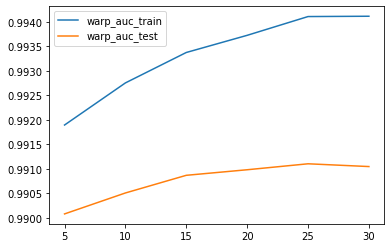

In [178]:
x1 = param_search_df[param_search_df.loss=="warp"].no_components
y1 = param_search_df[param_search_df.loss=="warp"].auc_train
plt.plot(x1, y1, label = "warp_auc_train")
x2 = param_search_df[param_search_df.loss=="warp"].no_components
y2 = param_search_df[param_search_df.loss=="warp"].auc_test
plt.plot(x2, y2, label = "warp_auc_test")
plt.legend()
plt.show()

no_components = 25 is best for warp

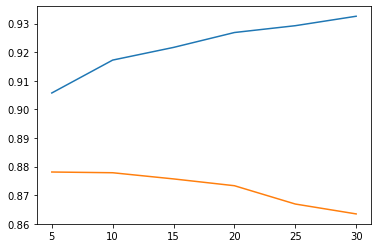

In [179]:
x3 = param_search_df[param_search_df.loss=="bpr"].no_components
y3 = param_search_df[param_search_df.loss=="bpr"].auc_train
plt.plot(x3, y3, label = "bpr_auc_train")
x4 = param_search_df[param_search_df.loss=="bpr"].no_components
y4 = param_search_df[param_search_df.loss=="bpr"].auc_test
plt.plot(x4, y4, label = "bpr_auc_test")

no_components = 5 is best for bpr

Generally warp is better than bpr for test result.

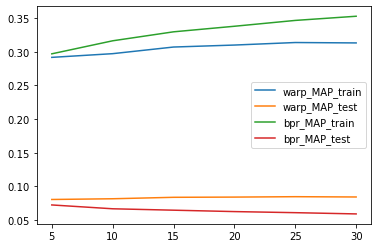

In [177]:
x1 = param_search_df[param_search_df.loss=="warp"].no_components
y1 = param_search_df[param_search_df.loss=="warp"].MAP_train
plt.plot(x1, y1, label = "warp_MAP_train")
x2 = param_search_df[param_search_df.loss=="warp"].no_components
y2 = param_search_df[param_search_df.loss=="warp"].MAP_test
plt.plot(x1, y2, label = "warp_MAP_test")
x3 = param_search_df[param_search_df.loss=="bpr"].no_components
y3 = param_search_df[param_search_df.loss=="bpr"].MAP_train
plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[param_search_df.loss=="bpr"].no_components
y4 = param_search_df[param_search_df.loss=="bpr"].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()

- Hybrid

In [239]:
hyperparameter_search("Hybrid_genres", parameter_combinations, train_interactions2, test_interactions2, item_features=item_features,verbose=True)

Training complete for one set of parameters. Time taken: 617.0411319732666
Training complete for one set of parameters. Time taken: 593.3146090507507
Training complete for one set of parameters. Time taken: 727.3680787086487
Training complete for one set of parameters. Time taken: 720.9481649398804
Training complete for one set of parameters. Time taken: 953.0193419456482
Training complete for one set of parameters. Time taken: 935.8746838569641
Training complete for one set of parameters. Time taken: 1276.8406298160553
Training complete for one set of parameters. Time taken: 1177.9624469280243
Training complete for one set of parameters. Time taken: 803.3708419799805
Training complete for one set of parameters. Time taken: 775.5469348430634
Training complete for one set of parameters. Time taken: 1031.6225259304047
Training complete for one set of parameters. Time taken: 930.4415709972382


In [326]:
hyperparameter_search("Hybrid_features_comb1_normalized", parameter_combinations, train_interactions3, test_interactions3, item_features=item_features2, verbose=True)

Training complete for one set of parameters. Time taken: 614.0722179412842
Training complete for one set of parameters. Time taken: 786.6177659034729
Training complete for one set of parameters. Time taken: 953.2289838790894
Training complete for one set of parameters. Time taken: 1126.5582468509674
Training complete for one set of parameters. Time taken: 1347.9920268058777
Training complete for one set of parameters. Time taken: 1515.320258140564


In [240]:
param_search_df[param_search_df.model_name == "PureCF"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,12.0,12.000000,12.000000,12.000000,12.000000,12.0,1.200000e+01,12.0,12.0,1.200000e+01,12.0,12.0,12.000000,1.200000e+01,12.000000,12.0
mean,20.0,0.073731,0.317785,0.931653,0.957771,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,17.500000,9.500000e-01,590.464765,0.0
std,0.0,0.010376,0.019905,0.061878,0.037721,0.0,2.211743e-22,0.0,0.0,7.247438e-18,0.0,0.0,8.918826,1.159590e-16,448.501566,0.0
min,20.0,0.059042,0.291714,0.863437,0.905723,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,9.500000e-01,281.964475,0.0
25%,20.0,0.064065,0.304612,0.875083,0.925563,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,10.000000,9.500000e-01,374.329936,0.0
50%,20.0,0.076433,0.313479,0.934087,0.962226,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,17.500000,9.500000e-01,484.728086,0.0
75%,20.0,0.083807,0.331753,0.990899,0.993463,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,25.000000,9.500000e-01,601.559224,0.0
max,20.0,0.084643,0.352837,0.991106,0.994114,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,30.000000,9.500000e-01,1953.422823,0.0


In [241]:
param_search_df[param_search_df.model_name == "Hybrid_genres"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,24.0,24.000000,24.000000,24.000000,24.000000,24.0,2.400000e+01,24.0,24.0,2.400000e+01,24.0,24.0,24.000000,2.400000e+01,24.000000,24.0
mean,20.0,0.058034,0.229643,0.903732,0.933586,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,36.666667,9.500000e-01,772.014383,0.0
std,0.0,0.024669,0.076705,0.088722,0.061743,0.0,4.326254e-22,0.0,0.0,1.417627e-17,0.0,0.0,23.529199,3.402305e-16,222.144898,0.0
min,20.0,0.032628,0.145121,0.807265,0.853260,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,9.500000e-01,409.909682,0.0
25%,20.0,0.033650,0.152703,0.817534,0.875796,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,18.750000,9.500000e-01,603.644490,0.0
50%,20.0,0.057591,0.226036,0.907135,0.938644,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,32.500000,9.500000e-01,751.457507,0.0
75%,20.0,0.082653,0.306879,0.990671,0.993895,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,52.500000,9.500000e-01,931.799849,0.0
max,20.0,0.083853,0.312044,0.991049,0.994468,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,80.000000,9.500000e-01,1276.840630,0.0


In [327]:
param_search_df[param_search_df.model_name == "Hybrid_features_comb1_normalized"].describe()

,@K,MAP_test,MAP_train,auc_test,auc_train,epochs,epsilon,item_alpha,k,learning_rate,max_sampled,n,no_components,rho,time,user_alpha
count,18.0,18.000000,18.000000,18.000000,18.000000,18.0,1.800000e+01,18.0,18.0,1.800000e+01,18.0,18.0,18.000000,1.800000e+01,18.000000,18.0
mean,20.0,0.060810,0.231302,0.931736,0.950482,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,27.500000,9.500000e-01,933.787916,0.0
std,0.0,0.029917,0.103658,0.085283,0.062633,0.0,2.178974e-22,0.0,0.0,1.428013e-17,0.0,0.0,16.999135,2.284820e-16,311.941680,0.0
min,20.0,0.017418,0.084148,0.809024,0.850367,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,5.000000,9.500000e-01,481.555425,0.0
25%,20.0,0.021509,0.091830,0.818374,0.871914,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,15.000000,9.500000e-01,671.134705,0.0
50%,20.0,0.080426,0.298316,0.989994,0.992983,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,25.000000,9.500000e-01,941.186977,0.0
75%,20.0,0.082505,0.307692,0.990731,0.993901,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,38.750000,9.500000e-01,1171.831405,0.0
max,20.0,0.082836,0.310579,0.990968,0.994279,5.0,1.000000e-06,0.0,5.0,5.000000e-02,10.0,10.0,60.000000,9.500000e-01,1515.320258,0.0


In [302]:
param_search_df.columns

Index(['@K', 'MAP_test', 'MAP_train', 'auc_test', 'auc_train', 'epochs',
       'epsilon', 'item_alpha', 'k', 'learning_rate', 'learning_schedule',
       'loss', 'max_sampled', 'model_name', 'n', 'no_components',
       'random_state', 'rho', 'time', 'user_alpha'],
      dtype='object')

- Hybrid graph

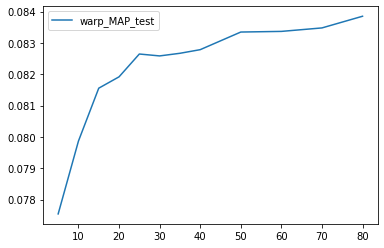

In [325]:
# x1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_genres")].no_components
# y1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_genres")].MAP_train
# plt.plot(x1, y1, label = "warp_MAP_train")
# x2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_genres")].no_components
# y2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_genres")].MAP_test
# plt.plot(x1, y2, label = "warp_MAP_test")
plt.legend()
plt.show()

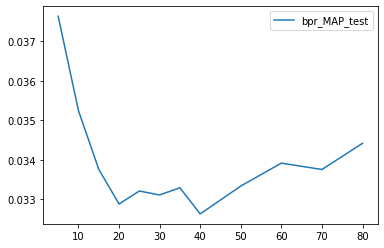

In [307]:
# x3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].no_components
# y3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].MAP_train
# plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].no_components
y4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_genres")].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()

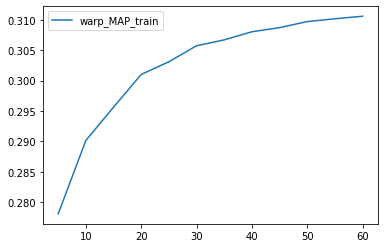

In [328]:
x1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
y1 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_train
plt.plot(x1, y1, label = "warp_MAP_train")
# x2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
# y2 = param_search_df[(param_search_df.loss=="warp") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_test
# plt.plot(x1, y2, label = "warp_MAP_test")
plt.legend()
plt.show()

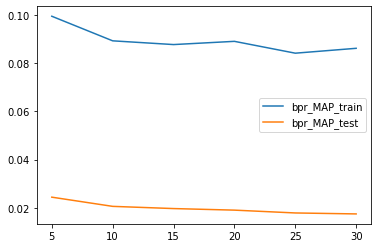

In [316]:
x3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
y3 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_train
plt.plot(x3, y3, label = "bpr_MAP_train")
x4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].no_components
y4 = param_search_df[(param_search_df.loss=="bpr") & (param_search_df.model_name=="Hybrid_features_comb1_normalized")].MAP_test
plt.plot(x4, y4, label = "bpr_MAP_test")
plt.legend()
plt.show()


## Model Evaluation using MAP@K
Mean average precision(MAP)@K and AUC score

In [ ]:
train_auc = auc_score(pure_cf, train_interactions).mean()
test_auc = auc_score(pure_cf, test_interactions).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
train_precision = precision_at_k(pure_cf, train_interactions, k=10).mean()
test_precision = precision_at_k(pure_cf, test_interactions,k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

In [ ]:
train_auc = auc_score(hybrid_model, train_interactions, item_features=item_features).mean()
test_auc = auc_score(hybrid_model, test_interactions, item_features=item_features).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [ ]:
train_precision = precision_at_k(hybrid_model, train_interactions, item_features=item_features, k=10).mean()
test_precision = precision_at_k(hybrid_model, test_interactions, item_features=item_features, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

## Make recommendations

- get userid/itemid/features mappings

In [ ]:
# set the dataset to the final model dataset
dataset = dataset1

In [ ]:
# mappings: (user id map, user feature map, item id map, item feature map)
mapping = dataset.mapping()

In [ ]:
item_features_mapping = mapping[3]
item_features_mapping

In [ ]:
# series used to use index(internal id) to locate the real id
user_series = pd.Series(mapping[0])
item_series = pd.Series(mapping[2])

In [ ]:
def getInternalId(real_id, series):
    return series[real_id]

In [ ]:
def getRawId(internal_id, series):
    return series[series == internal_id].index[0]

In [245]:
# raw id to internal id
getInternalId(76561198007712555, user_series)

NameError: name 'getInternalId' is not defined

In [ ]:
getRawId(68398, user_series)

- Make recommendations

In [ ]:
# print("Train precision: %.2f" % precision_at_k(pure_cf, data['train'], k=5).mean())
# print("Test precision: %.2f" % precision_at_k(pure_cf, data['test'], k=5).mean())

In [ ]:
user_id = 76561197970982479

In [ ]:
n_users, n_items = interactions.shape
internal_user_id = getInternalId(user_id, user_series)
all_scores = pd.Series(hybrid_model.predict(internal_user_id, np.arange(n_items)))

In [ ]:
all_scores

In [ ]:
# scores.index = np.arange(n_items)
all_ranks = list(pd.Series(all_scores.sort_values(ascending=False).index))

In [ ]:
all_ranks

In [ ]:
known_items = user_item_df[user_item_df.steam_id == user_id].item_id.sort_values()

In [ ]:
known_items_internal_ids = known_items.apply(getInternalId, args=(item_series,))

In [ ]:
ranks = [x for x in all_ranks if x not in known_items]

In [ ]:
ranks

In [ ]:
recommended_list = ranks[0:10]

In [ ]:
recommended_list_ids = [getRawId(id, item_series) for id in recommended_list]

In [ ]:
known_items_names = all_games.loc[all_games['item_id'].isin(known_items)]
known_items_names[:10]

In [ ]:
recommended_items_names = all_games.loc[all_games['item_id'].isin(recommended_list_ids)]
recommended_items_names